# Pacific Northwest Geodetic Array GPS Time Series Analysis

### [http://www.geodesy.cwu.edu](http://www.geodesy.cwu.edu)

In [2]:
from IPython.display import Image 
Image(url='http://www.geodesy.cwu.edu/graphics/banner3.1-resized.jpg')

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['GPS_DATA'] = '/Users/scott/Documents/GitHub/gpstools/panga/data/'
#os.environ['PANGA'] = '/Users/scott/Documents/GitHub/gpstools/panga'
import gpstools as gps

In [4]:
plt.style.use('seaborn-white')
%matplotlib notebook
%qtconsole

# Load time series

In [125]:
# We'll use station TPW2
station = 'TPW2'
# Reference frame is ITRF2008
# Download data
csv = gps.panga.download_data(station,overwrite=True, outdir=os.environ['GPS_DATA'])

Overwriting /Users/scott/Documents/GitHub/gpstools/panga/data/TPW2e.csv
Overwriting /Users/scott/Documents/GitHub/gpstools/panga/data/TPW2n.csv
Overwriting /Users/scott/Documents/GitHub/gpstools/panga/data/TPW2u.csv


In [126]:
# Load the timeseries as pandas dataframe
df = gps.panga.load_panga(station, os.environ['GPS_DATA'])

In [127]:
df.head()

,decyear,east,err_e,north,err_n,up,err_u
date,,,,,,,
2000-03-30,2000.24367,-43.44176,6.44261,-43.90224,4.16261,1.79662,15.36770
2000-03-31,2000.24641,-45.79030,3.04885,-37.59347,2.06967,-6.72731,6.70038
2000-04-01,2000.24914,-44.12896,3.01839,-38.36243,2.07357,-6.90083,6.51643
2000-04-02,2000.25188,-44.61936,3.02401,-37.61145,2.06194,-12.07732,6.56471
2000-04-03,2000.25462,-43.89246,3.06906,-38.40910,2.07690,-3.70381,6.68323


# Plot the time series

<IPython.core.display.Javascript object>


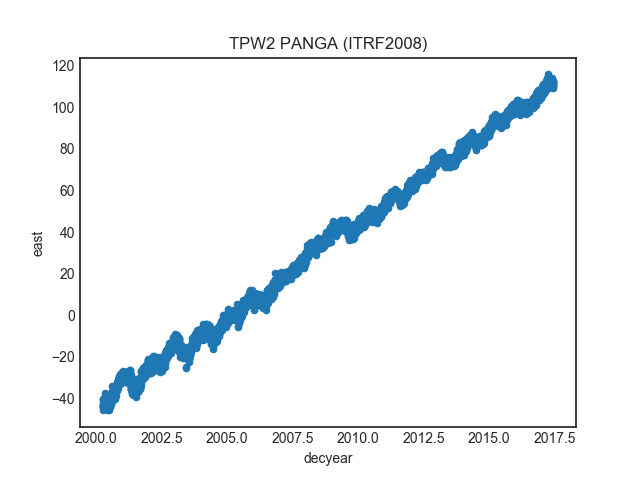

In [128]:
ax = df.plot.scatter('decyear', 'east', title=station + ' PANGA (ITRF2008)')

<IPython.core.display.Javascript object>


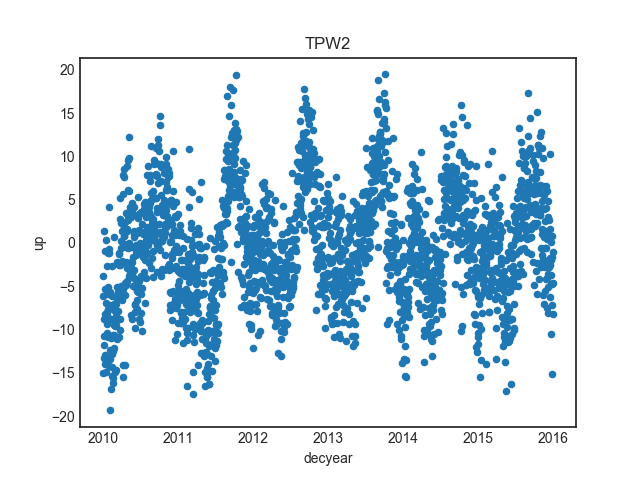

In [129]:
# Particular date range
df['2010/01/01':'2015/12/31'].plot.scatter('decyear', 'up', title=station)

<IPython.core.display.Javascript object>


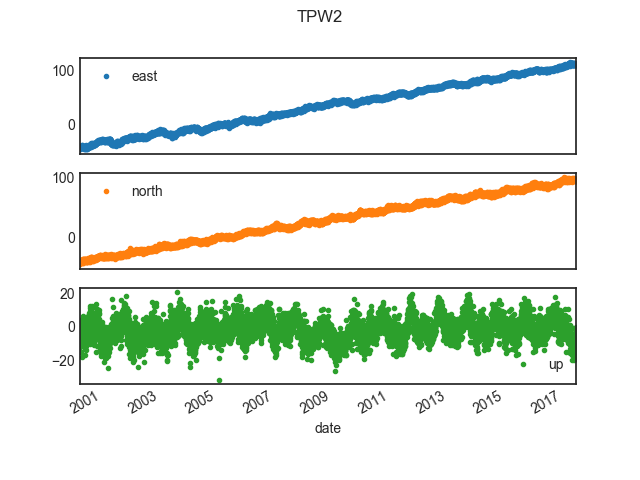

In [130]:
axes = df.plot(y=['east','north','up'], style='.' ,sharex=True, subplots=True, title=station)

# Query Panga archive, station info etc

### [Repository](http://www.geodesy.cwu.edu/pangagsac/gsacapi/repository/view)

http://www.unavco.org/gsacws/gsacapi/site/search?site.code.searchtype=exact&site.code=TPW2&output=site.html

many output types, including json and csv
http://www.unavco.org/gsacws/gsacapi/site/search?site.code.searchtype=exact&site.code=TPW2&output=site.json

PANGA instead of full UNAVCO database
http://www.geodesy.cwu.edu/pangagsac/gsacapi/site/search?site.code.searchtype=exact&output=site.html&limit=500&site.code=TPW2


download csv with station info
curl http://www.unavco.org/gsacws/gsacapi/site/search?bbox.north=49&bbox.west=-125&bbox.south=42&bbox.east=-120&output=site.csv

curl http://www.geodesy.cwu.edu/pangagsac/gsacapi/site/search?bbox.north=49&bbox.west=-125&bbox.south=42&bbox.east=-120&output=site.csv

In [ ]:
# Get info on all stations within a region
minlat = 42
maxlat = 49
minlon = -125
maxlon = -120


# Simple Map showing station location

In [84]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [165]:
def plot_map():
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()

    # frame station by box of several degrees
    frame=5 #degrees
    x0, y0 = plot_CRS.transform_point(dfs.lon-frame, dfs.lat-frame, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(dfs.lon+frame, dfs.lat+frame, geodetic_CRS)

    fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
                          subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ax.plot(dfs.lon, dfs.lat, 'ko',transform=geodetic_CRS)
    ax.text(dfs.lon, dfs.lat, station, fontweight='bold', transform=geodetic_CRS)

    ax.stock_img() # very low-res, but fast!
    ax.coastlines(resolution='50m') #10m is highest res

    states = cfeature.NaturalEarthFeature(scale='50m',
                                     category='cultural',
                                     name='admin_1_states_provinces_lakes')
    ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

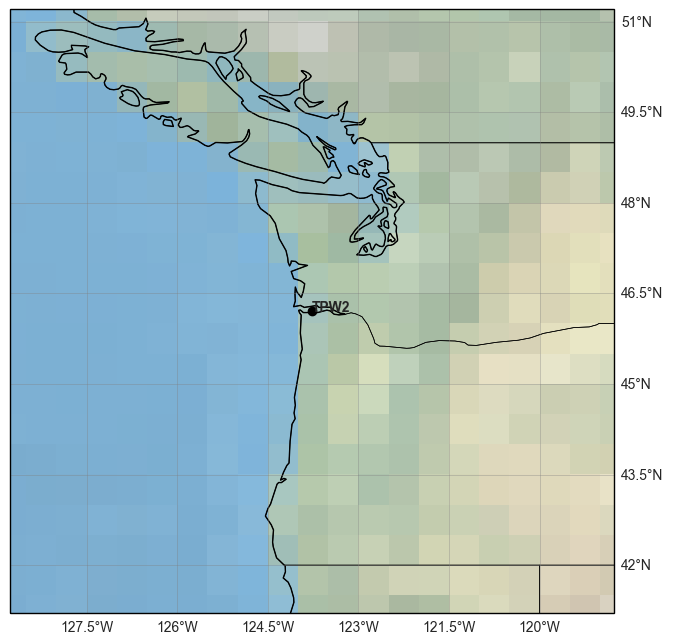

In [167]:
ax = plot_map()

In [219]:
# Find other GPS stations in the vicinity
dfS = gps.ungl.load_stations()
pad = 1 #degree
minlat = dfs.lat.values[0] - pad
maxlat = dfs.lat.values[0] + pad
minlon = dfs.lon.values[0] - pad
maxlon = dfs.lon.values[0] + pad
subset = dfS.query('(@minlat < lat < @maxlat) and (@minlon < lon < @maxlon)')

# Cull to the same time period
# for example, active after 2010, with minimal data gaps?
after = pd.Timestamp('2010-08-01')
subset = subset.query('end > @after')


In [220]:
print('{} stations in the vicinity'.format(len(subset)))
subset.head()

46 stations in the vicinity


,site,lat,lon,height,start,end
1901,CATH,46.1973,236.6327,56.364,2007-05-04,2015-07-26
2197,CHZZ,45.4865,236.0219,50.733,1999-10-13,2017-01-21
2409,COB1,45.4858,237.2026,46.878,2011-12-17,2017-01-19
2635,CROK,46.2746,237.0875,1.079,2007-05-05,2015-07-26
3848,FTS5,46.2049,236.0439,-13.712,2008-03-27,2016-08-09


(45, 48)

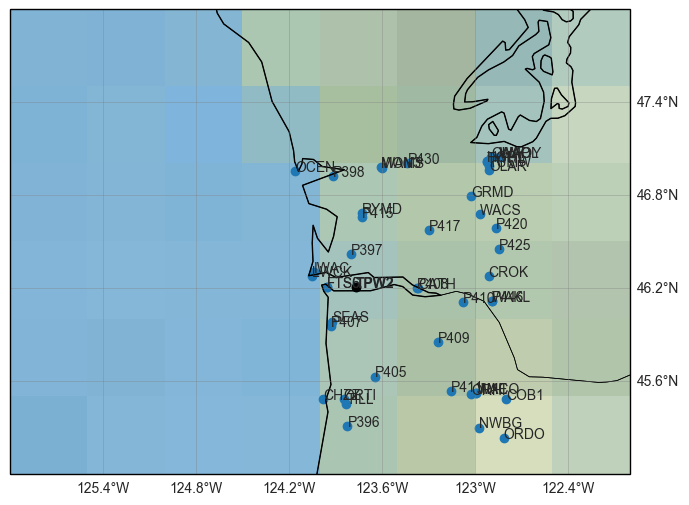

In [221]:

# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
ax = plot_map()
ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
for i in range(len(subset)):
    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], transform=ccrs.Geodetic())

plt.xlim(-126, -122)
plt.ylim(45,48)

In [222]:
# get distance to these other stations
import geopandas as gpd
from shapely.geometry import Point
geom = subset.apply(lambda row: Point(row.lon, row.lat), axis=1)
gf = gpd.GeoDataFrame(subset, crs="+init=epsg:4326", geometry=geom)
#gf['distance'] = gf.distance(Point(dfs.lon,dfs.lat))
 #NOTE this is in weird degree units. switch to UTM
#EPSG:32610 WGS84 10North

gf = gf.to_crs({'init': 'epsg:32610'})

site = gf.query('site == @station')

gf['distance'] = gf.distance( site.geometry.iloc[0])/1e3 #distance in kilometres
gf.sort_values('distance')

,site,lat,lon,height,start,end,geometry,distance
13873,TPW2,46.2074,236.2316,-14.973,2000-03-31,2017-01-21,POINT (440723.7789708629 5117378.40361983),0.000000
3849,FTS6,46.2052,236.0440,-13.502,2008-03-26,2016-08-09,POINT (426248.9694033101 5117291.174587799),14.475072
3848,FTS5,46.2049,236.0439,-13.712,2008-03-27,2016-08-09,POINT (426240.8533518889 5117257.934443687),14.483427
7794,LWCK,46.2781,235.9462,39.051,2012-02-11,2015-07-26,POINT (418811.7921511991 5125486.677437812),23.364059
5536,IWAC,46.3059,235.9606,-14.174,2007-12-07,2011-11-30,POINT (419961.721123543 5128560.936971465),23.582029
10461,P397,46.4216,236.2008,566.302,2007-03-21,2017-01-21,POINT (438587.8852033702 5141202.168989831),23.919319
12560,SEAS,45.9842,236.0776,-12.049,2008-08-24,2017-01-19,POINT (428556.2081854859 5092705.594333944),27.509949
10472,P408,46.2005,236.6234,35.273,2005-06-30,2017-01-21,POINT (470944.5074574248 5116393.731236944),30.236766
10471,P407,45.9546,236.0690,-13.123,2006-03-01,2017-01-21,POINT (427851.6795206179 5089424.611521271),30.775078
1901,CATH,46.1973,236.6327,56.364,2007-05-04,2015-07-26,POINT (471660.3767644109 5116034.815176642),30.965760


TPW2 already dowloaded... skipping
FTS6 already dowloaded... skipping
FTS6 already dowloaded... skipping
LWCK already dowloaded... skipping
IWAC already dowloaded... skipping
P397 already dowloaded... skipping
SEAS already dowloaded... skipping


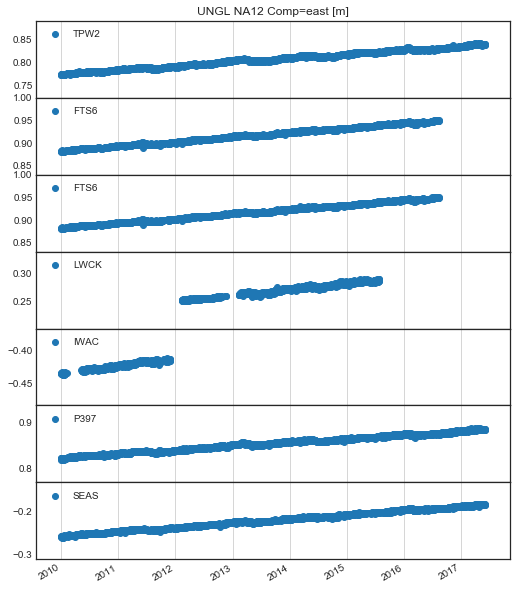

In [231]:
# Make a comparison plot for particular component, list of stations
sites = ['TPW2', 'FTS6', 'FTS6', 'LWCK', 'IWAC', 'P397', 'SEAS'] #less than 30km
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, figsize=(8.5,11))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False, outdir=os.environ['GPS_DATA'])
    tmp = gps.ungl.load_tenv3(tenv3)
    tmp = tmp['2010/01/01':'2017/06/01']#specific time range
    ax.scatter(tmp.index, tmp[comp],label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')

axes[0].set_title('UNGL NA12 Comp={} [m]'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

TPW2 already dowloaded... skipping


/Users/scott/Documents/GitHub/gpstools/analysis.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


east Rate [mm/yr]=8.686591340901794
RMSE =  0.00194147046307
FTS6 already dowloaded... skipping


/Users/scott/Documents/GitHub/gpstools/analysis.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


east Rate [mm/yr]=10.19125557563255
RMSE =  0.00141907425362
FTS6 already dowloaded... skipping
east Rate [mm/yr]=10.19125557563255
RMSE =  0.00141907425362
LWCK already dowloaded... skipping
east Rate [mm/yr]=10.443272914965677
RMSE =  0.00193159898813
IWAC already dowloaded... skipping
east Rate [mm/yr]=11.493185989532202
RMSE =  0.00173050900233
P397 already dowloaded... skipping
east Rate [mm/yr]=8.233423554901075
RMSE =  0.0019449967149
SEAS already dowloaded... skipping
east Rate [mm/yr]=9.84114787016411
RMSE =  0.00165822122429


(-10, 10)

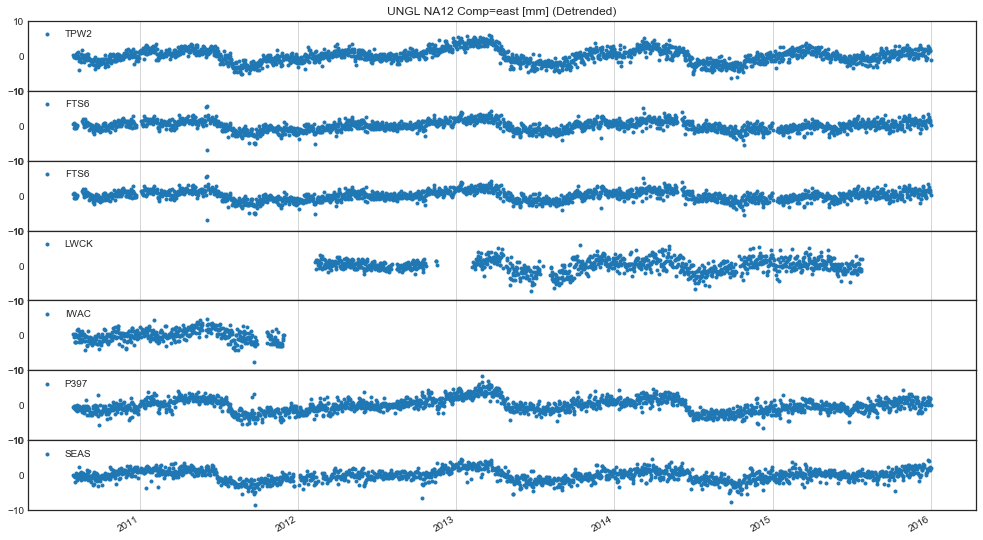

In [252]:
# Same plot, detrend the data
sites = ['TPW2', 'FTS6', 'FTS6', 'LWCK', 'IWAC', 'P397', 'SEAS'] #less than 30km
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False, outdir=os.environ['GPS_DATA'])
    tmp = gps.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/01/01':'2017/06/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp]*1e3,marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')

axes[0].set_title('UNGL NA12 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.ylim(-10,10)

# Fit velocity to timeseries

In [114]:
dfF = gps.analysis.fit_linear(df)

In [140]:
# Table of values
for comp in ['east','north','up']:
    x = df.decyear
    y = df[comp]
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    stderr = 2*np.sqrt(np.diag(cov))
    print('{}: {:.2f} +/- {:.2f} mm/yr'.format(comp, z[0]*1e3, stderr[0]*1e3))
    residuals = (p(x) - y)*1e3
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    print('rmse = {:.2f}'.format(rmse))

east: 8.64 +/- 0.01 mm/yr
rmse = 2.68
north: 7.02 +/- 0.01 mm/yr
rmse = 2.30
up: 0.05 +/- 0.03 mm/yr
rmse = 6.26


In [96]:
# Load MIDAS information
dfm = gps.ungl.load_midas(station, refframe)

In [97]:
dfm

,site,version,start,end,years,epochs,epochs_good,pairs,east,north,...,e0,n0,u0,out_e,out_n,out_u,sig_e,sig_n,sig_u,nsteps
5838,TPW2,MIDAS4,2000.2464,2017.5359,17.2895,6256,5781,8958,0.008387,0.007084,...,0.004275,0.003091,-0.007793,0.016,0.056,0.045,0.003364,0.001973,0.008029,4


In [141]:
print('MIDAS')
print('east: {:.2f} +/- {:.2f} mm/yr'.format(dfm.east.values[0]*1e3, dfm.err_e.values[0]*1e3))
print('north: {:.2f} +/- {:.2f} mm/yr'.format(dfm.north.values[0]*1e3, dfm.err_n.values[0]*1e3))
print('up: {:.2f} +/- {:.2f} mm/yr'.format(dfm.up.values[0]*1e3, dfm.err_u.values[0]*1e3))

MIDAS
East: 8.39 +/- 0.27 mm/yr
North: 7.08 +/- 0.16 mm/yr
Up: 0.36 +/- 0.65 mm/yr


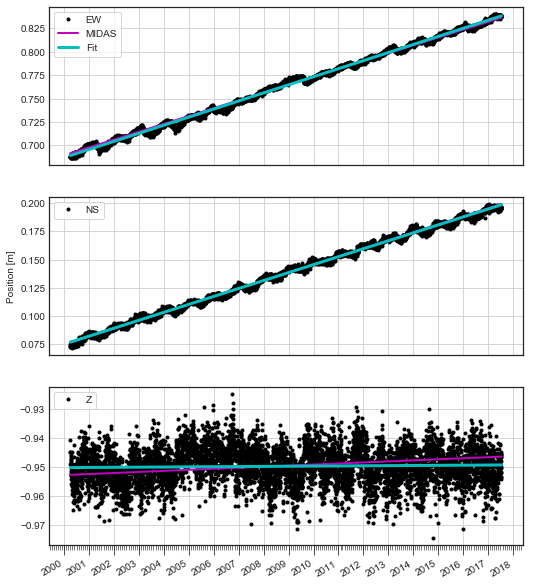

In [152]:
dfM = gps.ungl.add_midas(df, dfm)
gps.plot.all(df,dfFit=dfF, dfMidas=dfM)

# Compare to ETS catalogs

(733773.0, 736481.0)

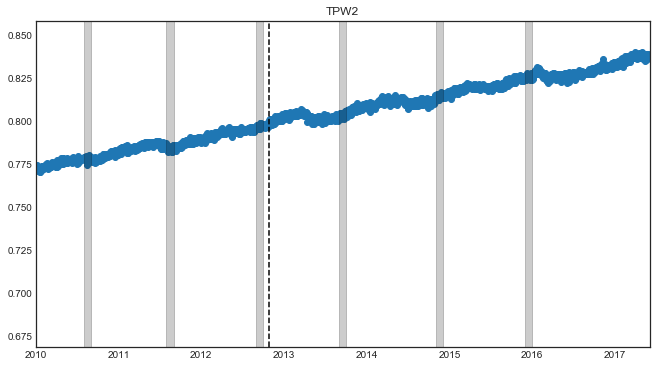

In [113]:
# Compare to database of ETS events:
# https://pnsn.org/tremor/overview
#p1 = pd.Period('2010-08')
#p1.start_time
#p1.end_time
#list of periods of interest from figure 3.3
ets = [pd.Period('2010-08'), 
       pd.Period('2011-08'), 
       pd.Period('2012-09'), 
       pd.Period('2013-09'),
       pd.Period('2014-11'),
       pd.Period('2015-12')]

fig,ax = plt.subplots(figsize=(11,6))
#not sure why not working interactively?
plt.scatter(df.index, df.east, label='East')
for i in range(len(df2)):
    plt.axvline(df2.date.iloc[i], color='k', linestyle='dashed', label='nearby EQ')


for p in ets:
    plt.axvspan(p.start_time, p.end_time, color='k', alpha=0.2)
plt.title(station)
#plt.legend()

plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2017-06-01'))